# Save Water

*NOTE: Focusing on just the lakes in the US for all the analysis below.*

## Goals
- Given the lake that was created in the middle on Manhattan can we identify other similar looking lakes?
- The big picture being, given a harmful feature, can we identify similar features on OpenStreetMap and are they harmful in nature?

## Data

Geojson of the harmful lake in the middle of Manhattan.
```json
{"type":"Feature","id":"way!481252780!2","properties":{"natural":"water","water":"lake","osm:type":"way","osm:id":481252780,"osm:version":2,"osm:changeset":47005897,"osm:timestamp":1490000491000,"osm:uid":3479270,"osm:user":"nammala"},"geometry":{"type":"MultiPolygon","coordinates":[[[[-74.006621,40.736432],[-74.0082566,40.7361974],[-74.008322,40.736188],[-74.0082979,40.7364619],[-74.008254,40.736961],[-74.006498,40.736957],[-74.006621,40.736432]]]]},"deleted":true}
```

## Features

### Analysis complete
- Area of the feature
- Number of nodes in the feature geometry
- Percentage of bbox covered by the feature
- Total number of user changesets \ features
- Does the feature have a name

### Analysis to do
- Type of the feature (node | way | relation)
- Has Wikipedia or Wikidata
- When was it created
- Number of primary tags
- What and the number of other tags
- Number of name translations

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn import ensemble

In [3]:
def get_length_of_name(name):
    if pd.isnull(name):
        return 0
    return len(name)

In [4]:
features = pd.read_csv('../data/save-water/lakes-us-with-features.csv')

features['feature_bbox_percentage'] = features['feature_area'] / features['feature_bbox_area']
features['feature_bbox_percentage'] = features['feature_bbox_percentage'].fillna(0)

features['name_length'] = features['name'].apply(get_length_of_name)
features['name_length'] = features['name_length'].fillna('')

print(features.shape)
features.head()

(16804, 15)


,feature_id,feature_type,feature_version,feature_area,feature_coordinates,feature_bbox_area,name,changeset_id,changeset_timestamp,user_id,user_name,user_changesets,user_features,feature_bbox_percentage,name_length
0,369314189,way,1,436663.24,44,675092.62,NaN,33823708,1441496842,3136691,Sonbelly,333.0,33900.0,0.646820,0
1,369314235,way,1,58240.41,13,89178.33,NaN,33823726,1441497047,3136691,Sonbelly,333.0,33900.0,0.653078,0
2,463110750,way,1,314065.63,83,636780.56,NaN,44828454,1483296754,3136691,Sonbelly,333.0,33900.0,0.493209,0
3,463113664,way,1,188710.26,36,387233.10,NaN,44828881,1483298439,3136691,Sonbelly,333.0,33900.0,0.487330,0
4,365998077,way,1,16203.76,13,25290.68,NaN,33371934,1439739482,3136691,Sonbelly,333.0,33900.0,0.640701,0


In [5]:
numericals = ['feature_version', 'feature_area', 'feature_coordinates', 'feature_bbox_area', 'feature_bbox_percentage', 'user_changesets', 'user_features']
numerical_features = features[numericals]
numerical_features = numerical_features.dropna()
print(numerical_features.shape)
numerical_features.head()

(16749, 7)


,feature_version,feature_area,feature_coordinates,feature_bbox_area,feature_bbox_percentage,user_changesets,user_features
0,1,436663.24,44,675092.62,0.646820,333.0,33900.0
1,1,58240.41,13,89178.33,0.653078,333.0,33900.0
2,1,314065.63,83,636780.56,0.493209,333.0,33900.0
3,1,188710.26,36,387233.10,0.487330,333.0,33900.0
4,1,16203.76,13,25290.68,0.640701,333.0,33900.0


# Feature 1 - Area of the feature

In [6]:
feature_area_harmful = 10425.51  # Area is in square meters.
print('Features with area less than or equal to harmful lake: {}'.format(features[features['feature_area'] <= feature_area_harmful].shape[0]))
print('Features with area greater than the harmful lake: {}'.format(features[features['feature_area'] > feature_area_harmful].shape[0]))
features['feature_area'].describe()

Features with area less than or equal to harmful lake: 8647
Features with area greater than the harmful lake: 8157


count    1.680400e+04
mean     8.447469e+04
std      1.202467e+06
min      0.000000e+00
25%      2.759888e+03
50%      9.753870e+03
75%      3.424321e+04
max      6.909368e+07
Name: feature_area, dtype: float64

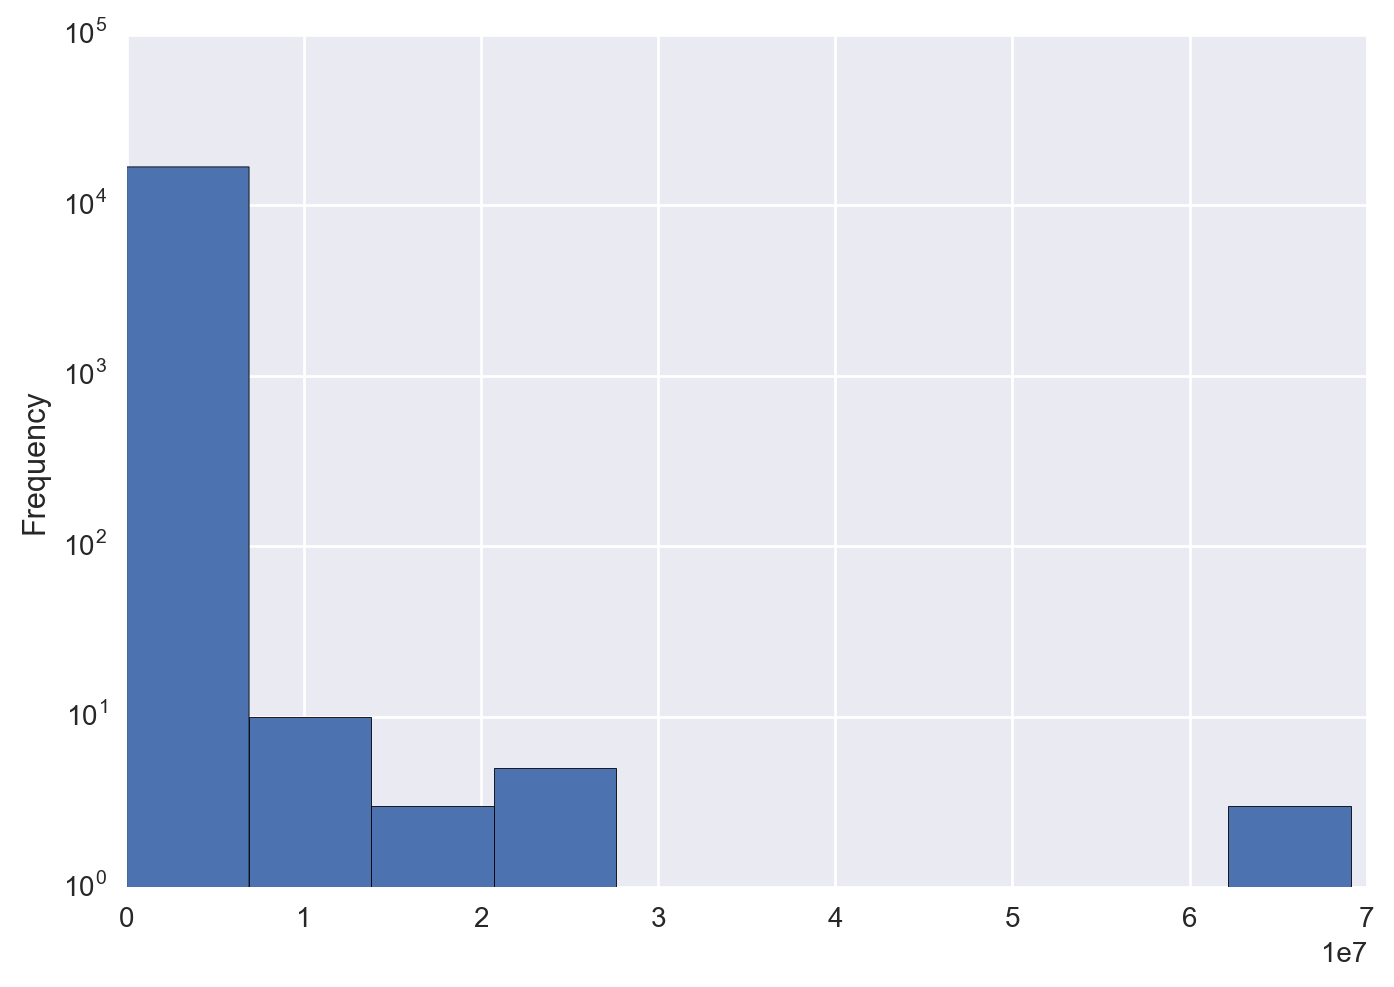

In [7]:
ax = features['feature_area'].plot.hist()
ax.set_yscale('log')

## Lakes with an area of zero

In [8]:
# Outliers: Lakes with area of zero.
features[features['feature_area'] == 0].head()

,feature_id,feature_type,feature_version,feature_area,feature_coordinates,feature_bbox_area,name,changeset_id,changeset_timestamp,user_id,user_name,user_changesets,user_features,feature_bbox_percentage,name_length
18,414865128,way,1,0.0,107,2961530.15,NaN,39025810,1462137351,3887039,rps333_imports,131.0,801138.0,0.0,0
140,463812890,way,1,0.0,2,78.33,Anderson Lake,44916285,1483599555,1230731,ScottNelson,1196.0,1391606.0,0.0,13
452,3765659229,node,1,0.0,1,0.00,Shoe Lake,34351283,1443632060,600730,sammuell_imports,474.0,9587117.0,0.0,9
1416,341953722,way,1,0.0,51,48661.57,NaN,30679954,1430452474,600730,sammuell_imports,474.0,9587117.0,0.0,0
2165,404782014,way,1,0.0,24,19382.92,NaN,37963254,1458505150,2758934,thexburnsx,28.0,11021.0,0.0,0


- Feature: http://www.openstreetmap.org/way/414865128
- Area of the lake is `0` as the way is un-closed.

<img width="1227" alt="screen shot 2017-03-22 at 8 08 41 am" src="https://cloud.githubusercontent.com/assets/2899501/24179721/d34f646e-0ed6-11e7-84d3-c1aee71e6975.png">

- Feature: http://www.openstreetmap.org/way/341953722
- Although visually looking great, the area is `0` as the geometry type is a `LineString` and not a `Polygon`

<img width="1227" alt="screen shot 2017-03-22 at 8 15 34 am" src="https://cloud.githubusercontent.com/assets/2899501/24179888/effd55c0-0ed7-11e7-933b-ec177fde97b5.png">

# Feature 2 - Number of coordinanates in the feature

In [9]:
feature_coordinates_harmful = 7
print('Features with coordinates less than or equal to harmful lake: {}'.format(features[features['feature_coordinates'] <= feature_coordinates_harmful].shape[0]))
print('Features with coordinates greater than harmful lake: {}'.format(features[features['feature_coordinates'] > feature_coordinates_harmful].shape[0]))
features['feature_coordinates'].describe()

Features with coordinates less than or equal to harmful lake: 1169
Features with coordinates greater than harmful lake: 15635


count    16804.000000
mean        33.867472
std         40.860425
min          1.000000
25%         13.000000
50%         22.000000
75%         39.000000
max        697.000000
Name: feature_coordinates, dtype: float64

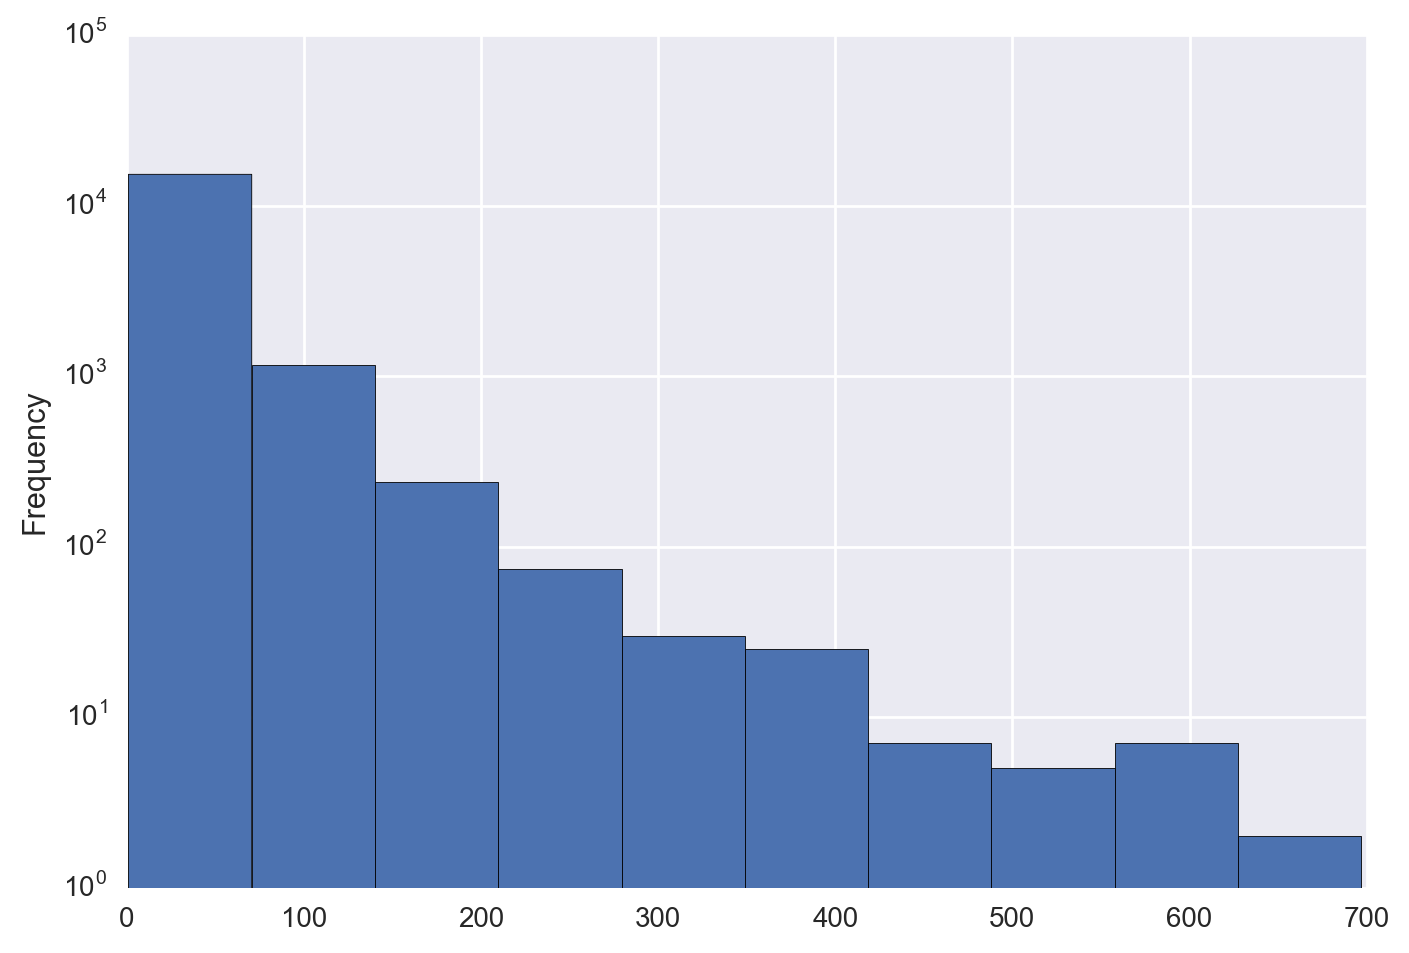

In [10]:
ax = features['feature_coordinates'].plot.hist()
ax.set_yscale('log')

In [11]:
# Outliers: Large number of cordinates
features[features['feature_coordinates'] > 600]

,feature_id,feature_type,feature_version,feature_area,feature_coordinates,feature_bbox_area,name,changeset_id,changeset_timestamp,user_id,user_name,user_changesets,user_features,feature_bbox_percentage,name_length
214,410107988,way,1,3167322.39,697,5171209.89,Pikitigushi Lake,38540892,1460586207,76077,Bootprint,10044.0,1315304.0,0.612492,16
3076,334724560,way,1,2278799.88,687,4177367.75,Leach Lake,29733585,1427307865,1752660,Barry McLane,1062.0,693767.0,0.545511,10


- Lakes tend to have higher number of coordinates, the mean being `33`.
- Larger lakes tend to be mapped as relations as the largest v1 lake, [way/410107988](http://www.openstreetmap.org/way/410107988) has 697 coordinates.

# Feature 3 - Percentage of bbox actually covered by feature

- A square feature covers the entire bbox and thus will have a percentage of 100%.
- The more square like or rectangular the feature, the higher the percentage.
- NOTE: Square features that are not orthogonal won't have 100% as the feature bbox's are always orthogonal.

In [12]:
feature_bbox_percentage_harmful = 0.78
print('Features with percenrage lesser than or equal to harmful lake: {}'.format(features[features['feature_bbox_percentage'] <= feature_bbox_percentage_harmful].shape[0]))
print('Features with percenrage greater than harmful lake: {}'.format(features[features['feature_bbox_percentage'] > feature_bbox_percentage_harmful].shape[0]))
features['feature_bbox_percentage'].describe()

Features with percenrage lesser than or equal to harmful lake: 16099
Features with percenrage greater than harmful lake: 705


count    16804.000000
mean         0.545144
std          0.161698
min          0.000000
25%          0.441487
50%          0.566168
75%          0.666575
max          1.000000
Name: feature_bbox_percentage, dtype: float64

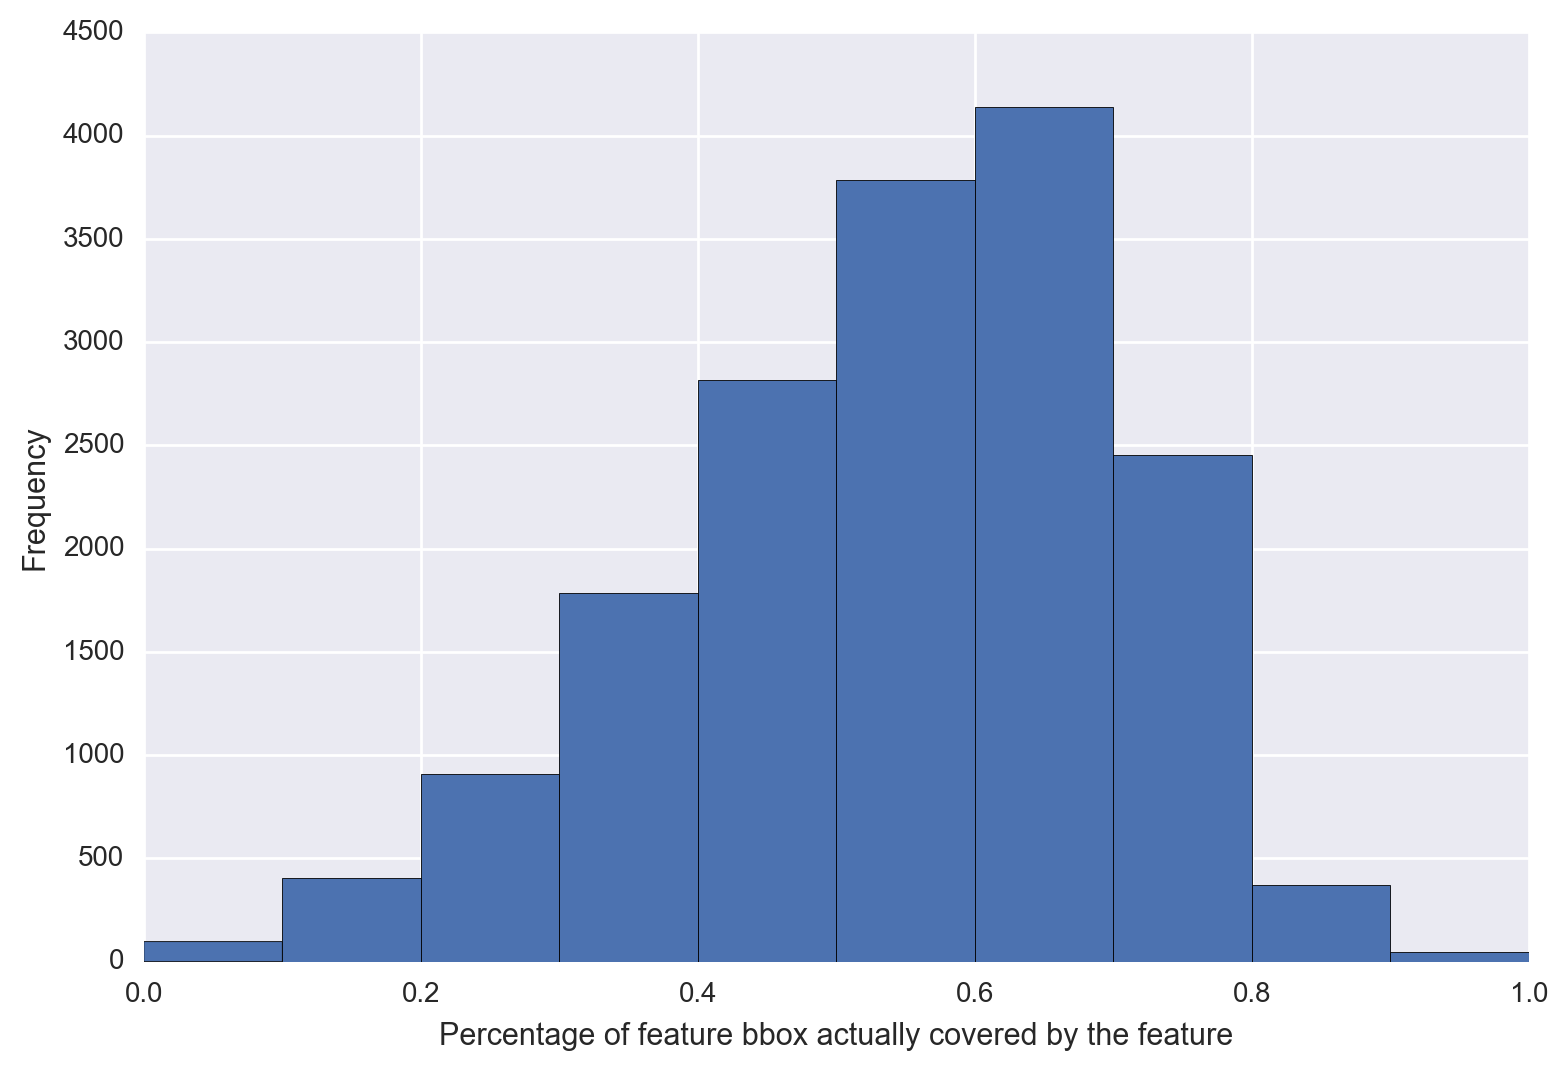

In [13]:
ax = features['feature_bbox_percentage'].plot.hist()
ax.set_xlabel('Percentage of feature bbox actually covered by the feature')
plt.tight_layout()

### Percentage of the feature bbox actually covered by feature is 100%

In [14]:
# The percentages are between 0 and 1.
features[features['feature_bbox_percentage'] == 1]

,feature_id,feature_type,feature_version,feature_area,feature_coordinates,feature_bbox_area,name,changeset_id,changeset_timestamp,user_id,user_name,user_changesets,user_features,feature_bbox_percentage,name_length
10514,366416160,way,1,1.73,5,1.73,NaN,33429678,1439953631,2937740,BreckT,555.0,44572.0,1.0,0
10896,405148327,way,1,0.01,4,0.01,Twin Pots Reservoir,38003606,1458666440,1501508,mash84121,2465.0,121979.0,1.0,19
12928,352613181,way,1,0.14,5,0.14,NaN,31847043,1433862939,143017,thekl0wn,857.0,83097.0,1.0,0
14196,442498678,way,1,2.77,5,2.77,NaN,42159869,1473889629,4577096,kennethdale1969,41.0,333.0,1.0,0


- Feature: http://www.openstreetmap.org/way/442498678/
- The feature is a rectangular lake created by a new user which he/she later deleted.
- TODO: Some false positives show up in the list as percentage=100%

<img width="1227" alt="screen shot 2017-03-22 at 10 33 36 am" src="https://cloud.githubusercontent.com/assets/2899501/24182988/464e45f2-0eeb-11e7-809a-6d8c006cc137.png">

# Feature 4: Number of changesets of the user

In [15]:
user_changesets_harmful = 3
print('Features with user changesets lesser than or equal to harmful lake: {}'.format(features[features['user_changesets'] <= user_changesets_harmful].shape[0]))
print('Features with user changesets greater than harmful lake: {}'.format(features[features['user_changesets'] > user_changesets_harmful].shape[0]))
features['user_changesets'].describe()

Features with user changesets lesser than or equal to harmful lake: 125
Features with user changesets greater than harmful lake: 16624


count     16749.000000
mean       5906.608932
std        8143.443159
min           0.000000
25%        1062.000000
50%        1786.000000
75%        7426.000000
max      103272.000000
Name: user_changesets, dtype: float64

- New users don't tend to create lakes.
- Just `125` out of `16749` lakes were created by users with changesets 3 or less.

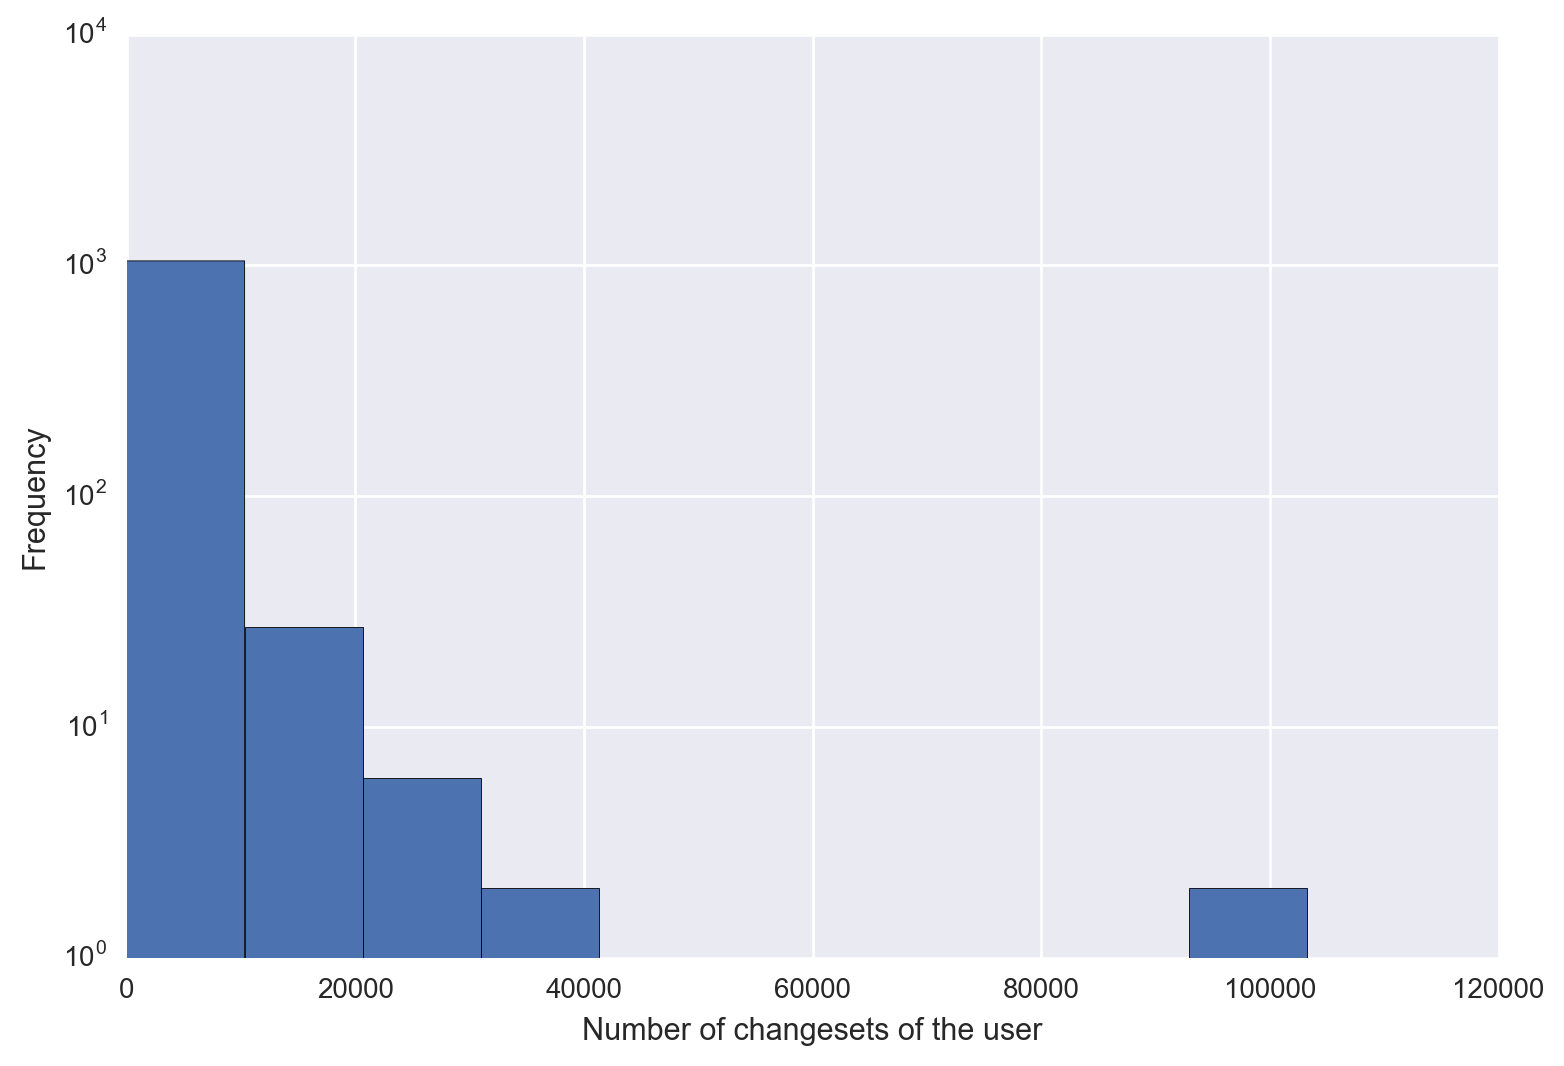

In [16]:
ax = features.drop_duplicates('user_name')['user_changesets'].plot.hist()
ax.set_yscale('log')
ax.set_xlabel('Number of changesets of the user')
plt.tight_layout()

## Lakes created by users with 0 changesets. What? Really?
- Issue with osm-comments-api, ticketed out here: https://github.com/mapbox/osm-comments-api/issues/65#issuecomment-288306225

In [17]:
features[features['user_changesets'] == 0]

,feature_id,feature_type,feature_version,feature_area,feature_coordinates,feature_bbox_area,name,changeset_id,changeset_timestamp,user_id,user_name,user_changesets,user_features,feature_bbox_percentage,name_length
11206,473632121,way,1,3307.76,17,4821.13,Lake,45954993,1486667152,5290698,DoctorTeeth,0.0,0.0,0.686096,4


- User [DoctorTeeth](http://www.openstreetmap.org/user/DoctorTeeth) is new to OpenStreetMap.
- Feature: http://www.openstreetmap.org/way/473631956
- Some documentation about mapping best practices would be amazing to share with the user.
- Ex: Building has the name `House` and lake has the name `Lake` and sometimes `Water Table`.

<img width="1227" alt="screen shot 2017-03-22 at 11 53 17 am" src="https://cloud.githubusercontent.com/assets/2899501/24184881/2c670af6-0ef6-11e7-9e66-e16a65f2553e.png">

# Feature 5: Does the lake have a name?

In [18]:
name_harmful = None
print('Features with name: {}'.format(features['name'].dropna().shape[0]))
print('Features without name: {}'.format(features['name'].isnull().sum()))
print('Percentage of v1 lakes with name: {}%'.format(int(100.0 * features['name'].dropna().shape[0] / features['name'].isnull().sum())))

Features with name: 4083
Features without name: 12721
Percentage of v1 lakes with name: 32%


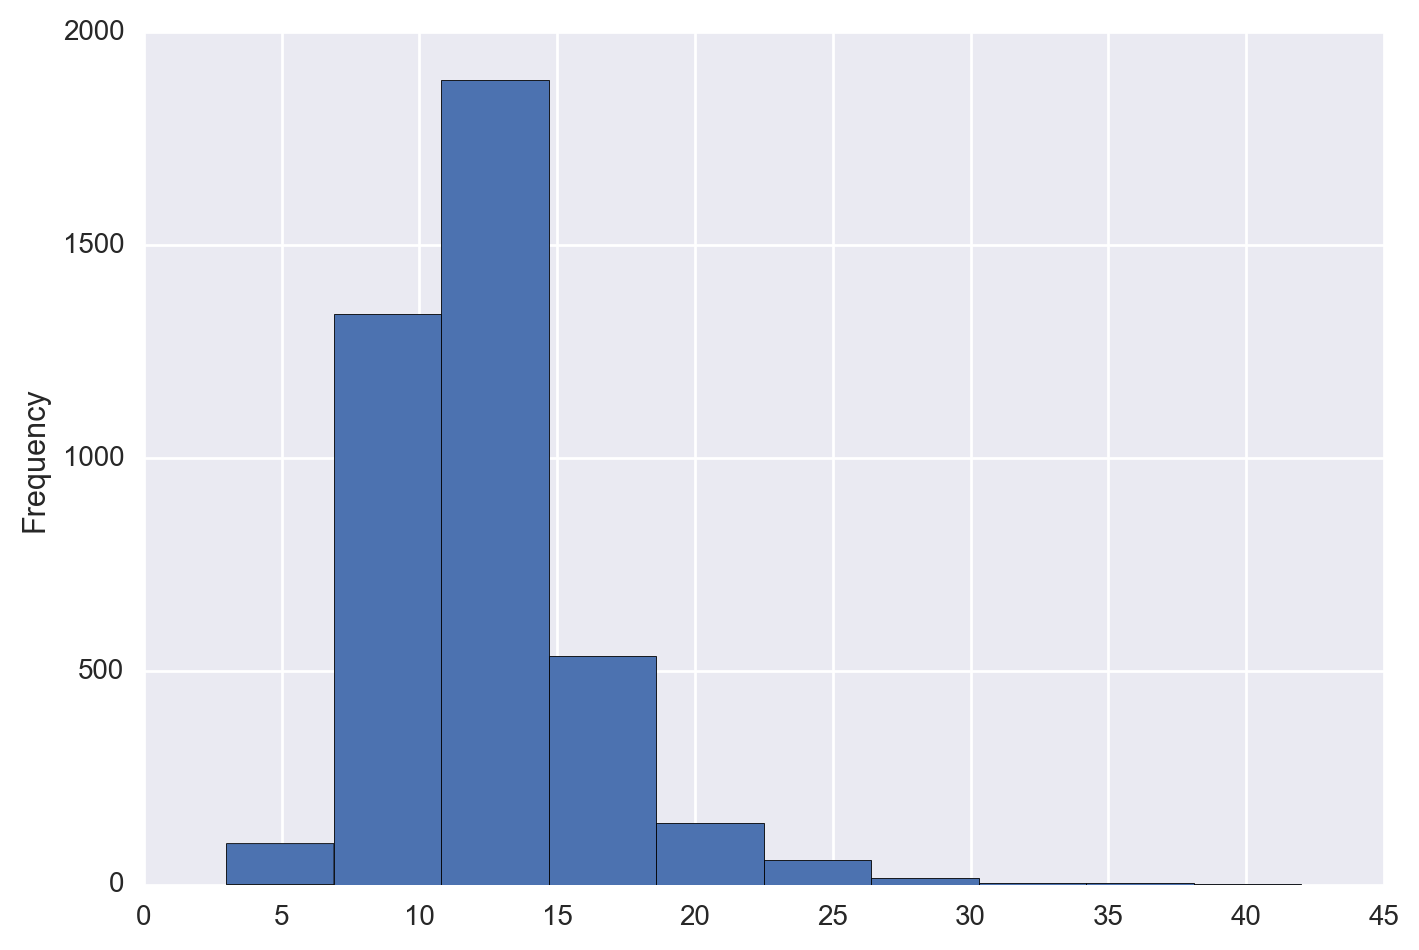

In [19]:
features[features['name_length'] > 0]['name_length'].plot.hist()

## What do small names look like?

In [20]:
features[(features['name_length'] > 0) & (features['name_length'] < 5)].head(10)

,feature_id,feature_type,feature_version,feature_area,feature_coordinates,feature_bbox_area,name,changeset_id,changeset_timestamp,user_id,user_name,user_changesets,user_features,feature_bbox_percentage,name_length
131,469253887,way,1,1031.79,6,1091.16,nope,45535982,1485476534,5202842,deered,2.0,16.0,0.945590,4
1831,352069135,way,1,15739.76,39,27094.96,Lake,31790747,1433685686,1320019,MindoMap,30.0,14326.0,0.580911,4
2025,256521511,way,1,121354.40,46,385257.10,Buck,19983183,1389666539,1853994,pierrecoucat,123.0,15018.0,0.314996,4
2283,254196588,way,1,53382.22,35,157586.44,Jog,19700220,1388337283,1853994,pierrecoucat,123.0,15018.0,0.338749,3
2869,343135985,way,1,15496.06,14,24379.67,Lake,30830335,1430890271,1320019,MindoMap,30.0,14326.0,0.635614,4
7422,437897746,way,1,2679.65,14,4534.83,Lake,41547225,1471572832,385046,Palolo,6319.0,2630484.0,0.590904,4
8182,361994848,way,1,44374.60,58,135286.79,9678,32840492,1437706110,2937740,BreckT,555.0,44572.0,0.328004,4
8188,361996659,way,1,10629.64,7,13900.04,9641,32840832,1437709429,2937740,BreckT,555.0,44572.0,0.764720,4
8354,361999981,way,1,39340.66,19,75201.35,9535,32841086,1437712400,2937740,BreckT,555.0,44572.0,0.523138,4
8356,361999959,way,1,22185.04,12,38685.89,9053,32841086,1437712398,2937740,BreckT,555.0,44572.0,0.573466,4


- Feaure: http://www.openstreetmap.org/way/469253887
- A new user, [deered](http://www.openstreetmap.org/user/deered) with 2 changesets creates a lake with name "`nope`" with changeset comment "`please ignore`".
- The satellite imagery shows no water body in the region

<img width="1226" alt="screen shot 2017-03-22 at 12 13 21 pm" src="https://cloud.githubusercontent.com/assets/2899501/24185419/1989c3e4-0ef9-11e7-87fd-631c6ddbb562.png">

Another feature by the same user.
- Feature: http://www.openstreetmap.org/way/125564093
- The user added `natural=water`, `water=lake` and removed `tourism=hotel`, clearly some form of vandalism.
<img width="1224" alt="screen shot 2017-03-22 at 12 17 17 pm" src="https://cloud.githubusercontent.com/assets/2899501/24185535/99360846-0ef9-11e7-98ca-2b438fcebd6f.png">


## What do the large names look like?

In [21]:
features[features['name_length'] > 35].head(10)

,feature_id,feature_type,feature_version,feature_area,feature_coordinates,feature_bbox_area,name,changeset_id,changeset_timestamp,user_id,user_name,user_changesets,user_features,feature_bbox_percentage,name_length
9491,229220656,way,1,61895.20,105,119449.62,Midlothian Creek Detention Reservoir,16879695,1373317748,518622,terremoto73,133.0,6507.0,0.518170,36
11620,391286307,way,1,171123.52,158,455991.45,Herrington Manor Recreation Area Reservoir,36560084,1452720730,247807,asciiphil,3573.0,2801326.0,0.375278,42
11764,391286307,way,1,14043.40,28,20378.14,Herrington Manor Recreation Area Reservoir,36560084,1452720730,247807,asciiphil,3573.0,2801326.0,0.689140,42


- Things looks good on the large names side. Yay!

In [22]:
# assert False

# Exploratory data analysis

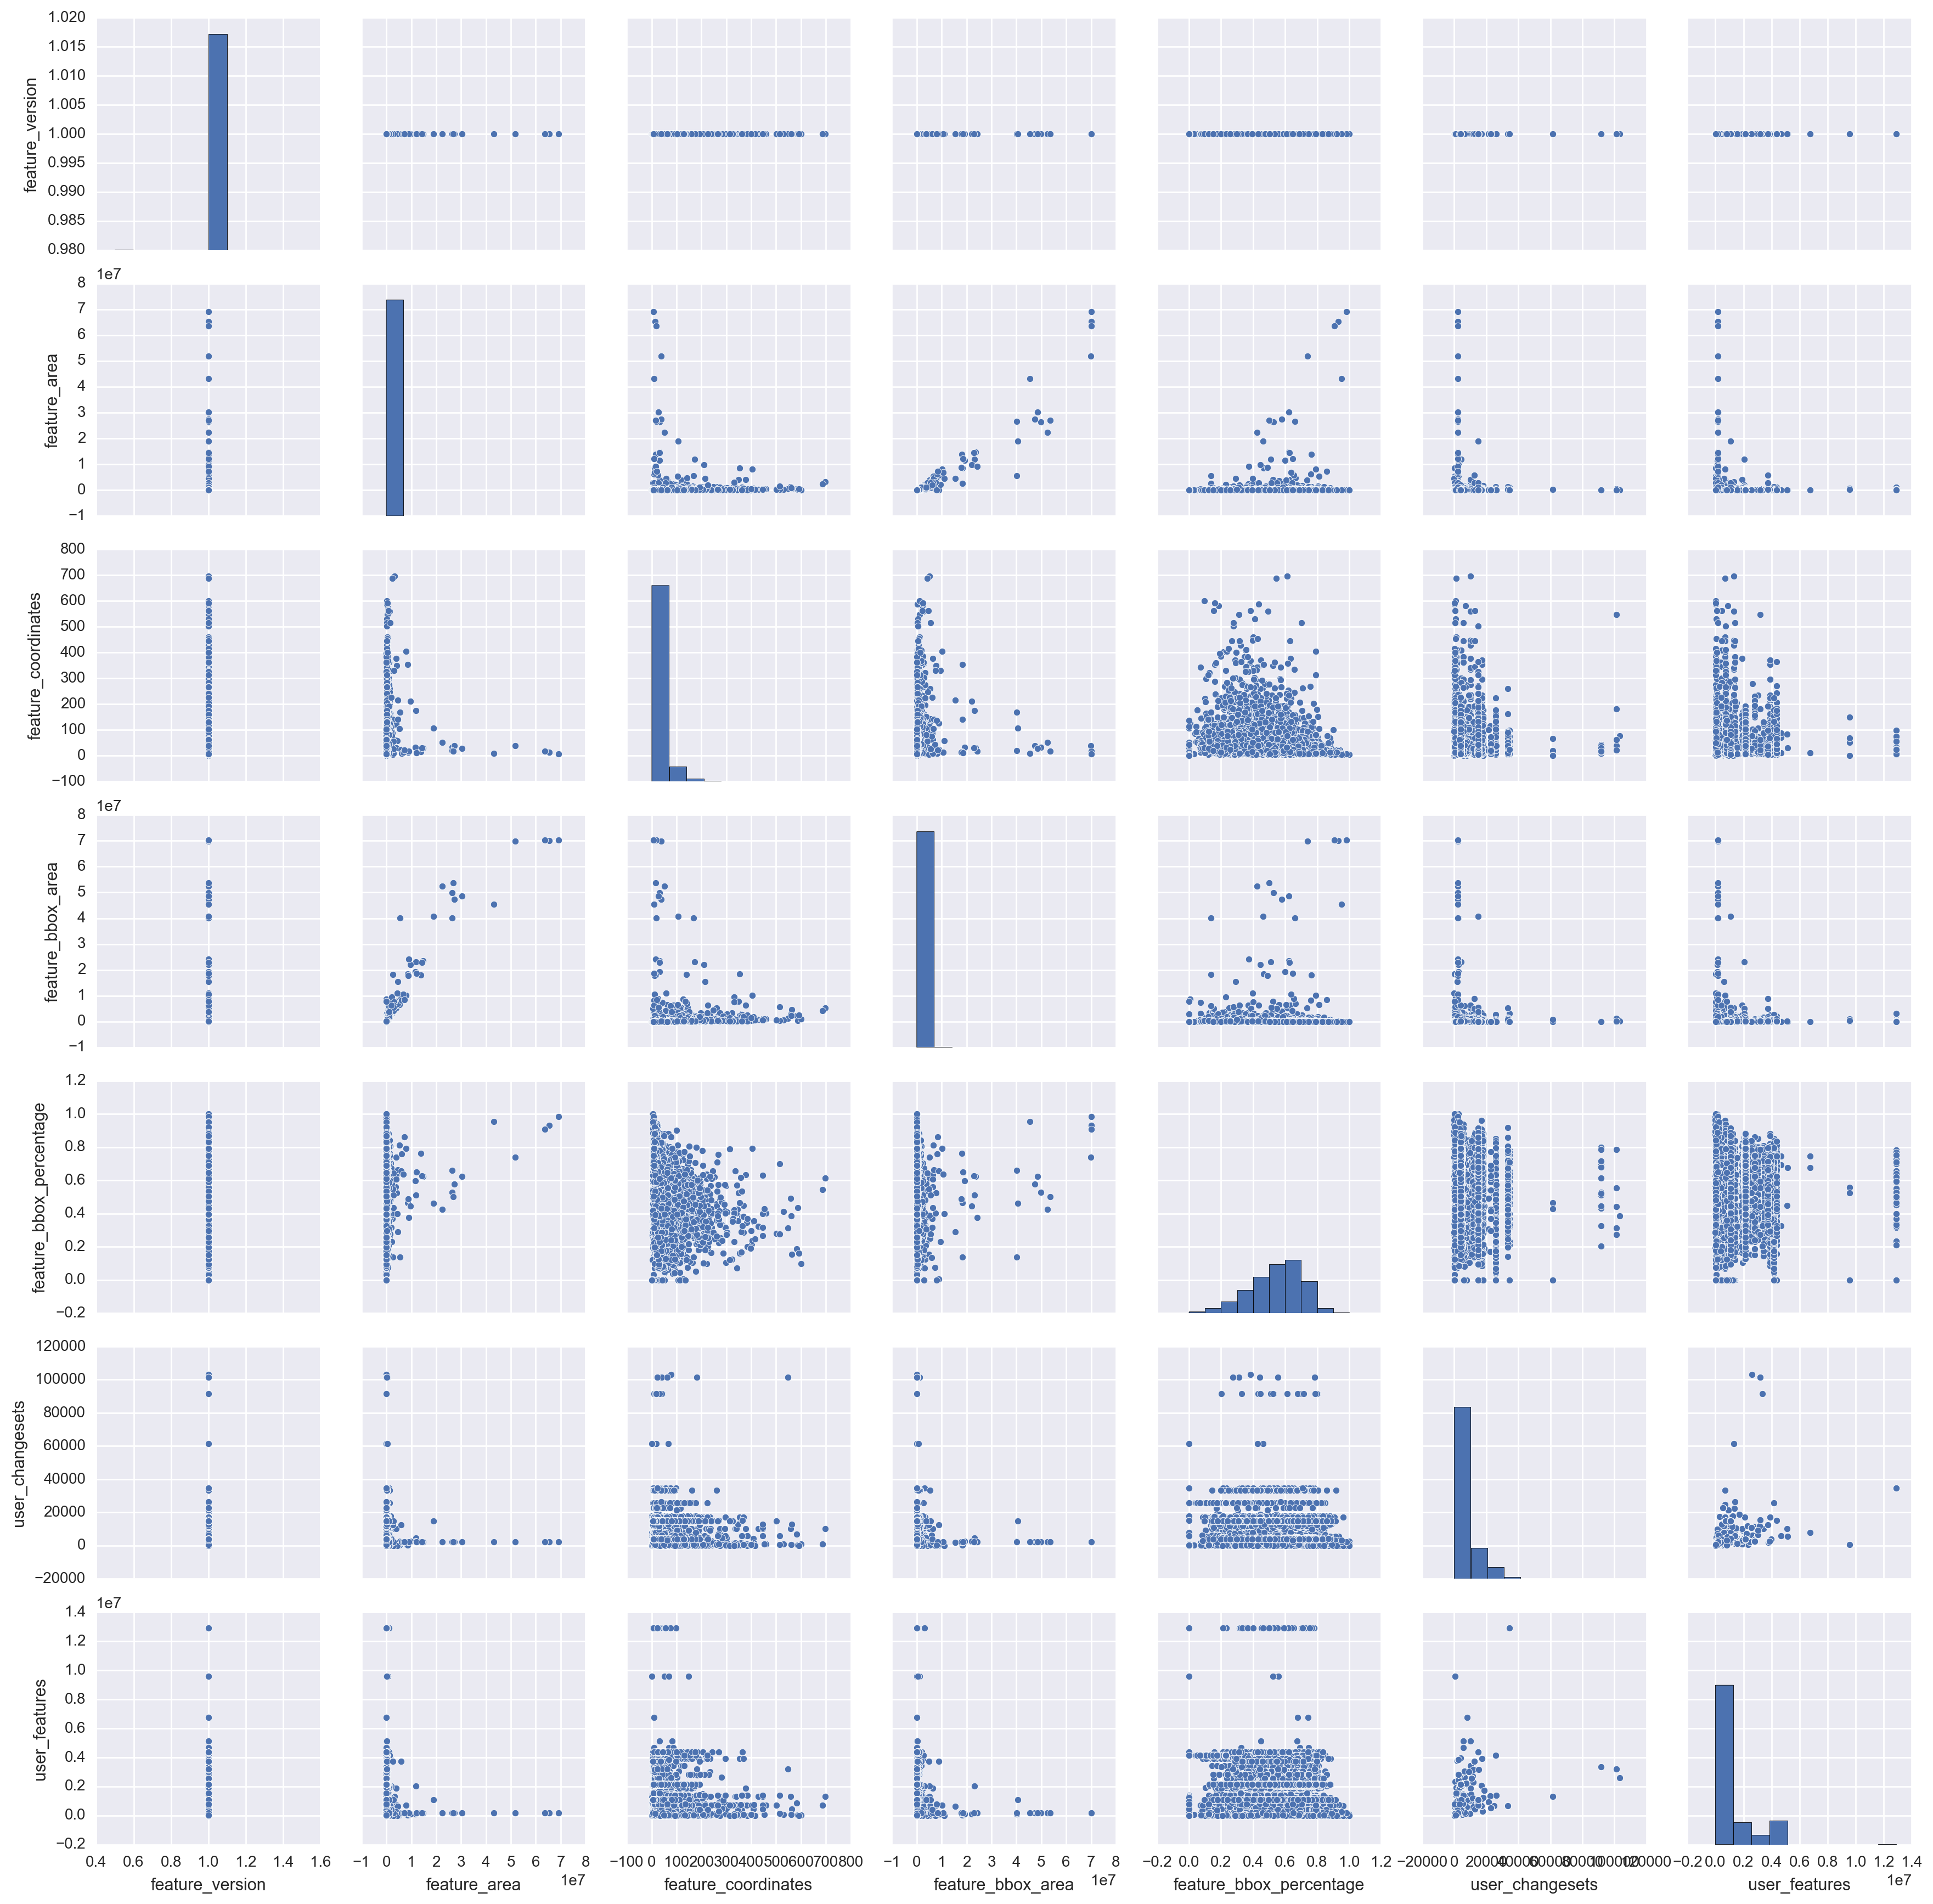

In [23]:
sns.pairplot(numerical_features)

# Outlier Detection

In [24]:
# Scaling features before training the classifier
scaler = preprocessing.StandardScaler().fit(numerical_features)
numerical_features = pd.DataFrame(scaler.transform(numerical_features), columns=numericals)
numerical_features.head()

,feature_version,feature_area,feature_coordinates,feature_bbox_area,feature_bbox_percentage,user_changesets,user_features
0,0.0,0.292641,0.248018,0.306378,0.628005,-0.684449,-0.776989
1,0.0,-0.021637,-0.510714,-0.044322,0.666738,-0.684449,-0.776989
2,0.0,0.190824,1.202553,0.283446,-0.322720,-0.684449,-0.776989
3,0.0,0.086718,0.052216,0.134079,-0.359104,-0.684449,-0.776989
4,0.0,-0.056548,-0.510714,-0.082562,0.590134,-0.684449,-0.776989


In [25]:
# Training the classifier
clf = ensemble.IsolationForest()
clf.fit(numerical_features)
clf

IsolationForest(bootstrap=False, contamination=0.1, max_features=1.0,
        max_samples='auto', n_estimators=100, n_jobs=1, random_state=None,
        verbose=0)

In [26]:
def get_prediction(item):
    return clf.predict(scaler.transform([item[numericals]]))

features['prediction'] = features[numericals].dropna().apply(get_prediction, axis=1)['feature_area']

print('Total: {}'.format(features.shape[0]))
print('Number of outliers: {}'.format(features[features['prediction'] == -1].shape[0]))
print('Number of inliers: {}'.format(features[features['prediction'] == 1].shape[0]))

Total: 16804
Number of outliers: 1675
Number of inliers: 15074


- NOTE: 10% of features are detected as outliers which is interesting.
- Basically, the algorithm thinks these features are different from the rest after looking at all the parameters.

In [27]:
features[features['prediction'] == -1].drop_duplicates('feature_id').head()

,feature_id,feature_type,feature_version,feature_area,feature_coordinates,feature_bbox_area,name,changeset_id,changeset_timestamp,user_id,user_name,user_changesets,user_features,feature_bbox_percentage,name_length,prediction
0,369314189,way,1,436663.24,44,675092.62,NaN,33823708,1441496842,3136691,Sonbelly,333.0,33900.0,0.646820,0,-1.0
2,463110750,way,1,314065.63,83,636780.56,NaN,44828454,1483296754,3136691,Sonbelly,333.0,33900.0,0.493209,0,-1.0
18,414865128,way,1,0.00,107,2961530.15,NaN,39025810,1462137351,3887039,rps333_imports,131.0,801138.0,0.000000,0,-1.0
45,365345808,way,1,525791.95,37,1225111.62,NaN,33293706,1439391604,3136691,Sonbelly,333.0,33900.0,0.429179,0,-1.0
81,414865266,way,1,75533.83,35,372023.17,NaN,39025810,1462137369,3887039,rps333_imports,131.0,801138.0,0.203035,0,-1.0
